# Методы исследования характеристических свойств нейронных сетей с применением теоретико-игрового подхода

- **Теория**: И.В.Томилов ivan-tomilov3@yandex.ru
- **Реализация**: М.А.Зайцева maria@tail-call.ru
- **Поддержка CUDA**: А.Е.Григорьева admin@linkennt.ru
- **Ревизия**: 8

- **Другие ревизии**: [ссылка](https://disk.yandex.ru/d/aZozDpBlzh_z1A)
<!-- please do not append text into this block -->

- [ ] Добавить 2x больше эпох на датасетах, где был плохой перфоманс
- [x] Примешивать к целевой переменной на этапе обучения шум с амплитудой ~0,03 дисперсии
- [ ] Третий пункт был связан со стабильными распределениями и варьированием ɑ от 1 до 2 — этот стабильный шум надо тоже к целевой переменной примешивать

## Setup

In [1]:
from cgtnnlib.constants import LEARNING_RATE, RANDOM_STATE
import cgtnnlib.training as tr
import cgtnnlib.datasets as ds
from cgtnnlib.ExperimentParameters import ExperimentParameters
from cgtnnlib.NoiseGenerator import target_dispersion_scaled_noise


iterations = 10
epochs = 10
datasets = [
    ds.datasets['StudentPerformanceFactors'],
    ds.datasets['wine_quality'],
]
noise_generators = [target_dispersion_scaled_noise(
    dataset=dataset,
    factor=0.03,
    random_seed=RANDOM_STATE + 1,
) for dataset in datasets]
p = 0.9


TORCH_DEVICE is cpu
target_dispersion_scaled_noise(Dataset #3 {
  name: "StudentPerformanceFactors"
  learning_task: LearningTask(name='regression', criterion=MSELoss(), dtype=torch.float32)
  classes_count: 1
  target: "Exam_Score"
  _data: DatasetData(df=      Hours_Studied  Attendance  Parental_Involvement  Access_to_Resources  \
0                23          84                    -1                    1   
1                19          64                    -1                    0   
2                24          98                     0                    0   
3                29          89                    -1                    0   
4                19          92                     0                    0   
...             ...         ...                   ...                  ...   
6602             25          69                     1                    0   
6603             23          76                     1                    0   
6604             20          90          

## Training

both take ~5m 06s to train 10 iterations

- `ds.datasets['StudentPerformanceFactors']` takes ~2m 30s to train 10 iterations
- `ds.datasets['wine_quality']` takes ~2m 36s to train 10 iterations

In [2]:

for i, grouping_key in enumerate(datasets):
    noise_generator = noise_generators[i]
    for iteration in range(iterations):
        experiment_params = ExperimentParameters(iteration, p=p)

        tr.create_and_train_model(
            grouping_key,
            epochs,
            learning_rate=LEARNING_RATE,
            dry_run=False,
            p=p,
            iteration=iteration,
            noise_generator=noise_generator
        )

N=9 #6 gTDS6 p=0.9 E9/10 S434 Loss=0.0041@AugmentedReLUNetwork
create_and_train_model(): saved model to pth/cgtnn-6Y-AugmentedReLUNetwork-gTDS6-P0.9_N9.pth
Report saved to pth/cgtnn-6Y-AugmentedReLUNetwork-gTDS6-P0.9_N9.json.


## Evaluation

both take 42s

In [3]:
from cgtnnlib.EvaluationParameters import EvaluationParameters
from cgtnnlib.Report import Report
from cgtnnlib.nn.AugmentedReLUNetwork import AugmentedReLUNetwork
import cgtnnlib.evaluate as ev
import cgtnnlib.datasets as ds
import cgtnnlib.path as ph
from cgtnnlib.ExperimentParameters import ExperimentParameters


iterations = 10
epochs = 10
grouping_key = ds.datasets[2]
p = 0.9


for i, grouping_key in enumerate(datasets):
    noise_generator = noise_generators[i]
    for iteration in range(iterations):
        experiment_params = ExperimentParameters(iteration, p=p)
        
        eval_params = EvaluationParameters(
            dataset=grouping_key,
            model_path=ph.model_path(
                dataset_number=grouping_key.number,
                model_type=AugmentedReLUNetwork,
                p=p,
                iteration=iteration,
                noise_generator=noise_generator,
            ),
            experiment_parameters=experiment_params,
            report_key=ph.eval_report_key(
                model_name=AugmentedReLUNetwork.__name__,
                dataset_number=grouping_key.number,
                p=p,
                iteration=iteration,
            )
        )
        
        report_name = ph.model_name(
            dataset_number=grouping_key.number,
            model_type=AugmentedReLUNetwork,
            p=p,
            iteration=iteration,
            noise_generator=noise_generator
        )

        report = Report(
            dir='pth/',
            filename=report_name + '.json',
            must_exist=True,
        )
        
        ev.eval_inner(
            eval_params=eval_params,
            constructor=AugmentedReLUNetwork,
            report=report
        )
        
        report.save()

Evaluating model at pth/cgtnn-6Y-AugmentedReLUNetwork-gTDS6-P0.9_N9.pth...
Report saved to pth/cgtnn-6Y-AugmentedReLUNetwork-gTDS6-P0.9_N9.json.


## Analysis

group cgtnn-3-AugmentedReLUNetwork-gTDS3-0.9
rows <class 'pandas.core.frame.DataFrame'>
Report found at pth/cgtnn-3Y-AugmentedReLUNetwork-gTDS3-P0.9_N0.json. Loading...
Report loaded.
Report found at pth/cgtnn-3Y-AugmentedReLUNetwork-gTDS3-P0.9_N1.json. Loading...
Report loaded.
Report found at pth/cgtnn-3Y-AugmentedReLUNetwork-gTDS3-P0.9_N6.json. Loading...
Report loaded.
Report found at pth/cgtnn-3Y-AugmentedReLUNetwork-gTDS3-P0.9_N7.json. Loading...
Report loaded.
Report found at pth/cgtnn-3Y-AugmentedReLUNetwork-gTDS3-P0.9_N8.json. Loading...
Report loaded.
Report found at pth/cgtnn-3Y-AugmentedReLUNetwork-gTDS3-P0.9_N4.json. Loading...
Report loaded.
Report found at pth/cgtnn-3Y-AugmentedReLUNetwork-gTDS3-P0.9_N5.json. Loading...
Report loaded.
Report found at pth/cgtnn-3Y-AugmentedReLUNetwork-gTDS3-P0.9_N9.json. Loading...
Report loaded.
Report found at pth/cgtnn-3Y-AugmentedReLUNetwork-gTDS3-P0.9_N2.json. Loading...
Report loaded.
Report found at pth/cgtnn-3Y-AugmentedReLUNetwor

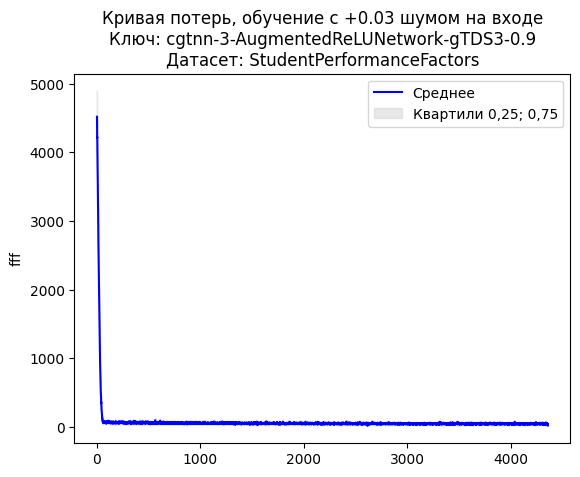

group cgtnn-6-AugmentedReLUNetwork-gTDS6-0.9
rows <class 'pandas.core.frame.DataFrame'>
Report found at pth/cgtnn-6Y-AugmentedReLUNetwork-gTDS6-P0.9_N6.json. Loading...
Report loaded.
Report found at pth/cgtnn-6Y-AugmentedReLUNetwork-gTDS6-P0.9_N7.json. Loading...
Report loaded.
Report found at pth/cgtnn-6Y-AugmentedReLUNetwork-gTDS6-P0.9_N0.json. Loading...
Report loaded.
Report found at pth/cgtnn-6Y-AugmentedReLUNetwork-gTDS6-P0.9_N1.json. Loading...
Report loaded.
Report found at pth/cgtnn-6Y-AugmentedReLUNetwork-gTDS6-P0.9_N2.json. Loading...
Report loaded.
Report found at pth/cgtnn-6Y-AugmentedReLUNetwork-gTDS6-P0.9_N3.json. Loading...
Report loaded.
Report found at pth/cgtnn-6Y-AugmentedReLUNetwork-gTDS6-P0.9_N8.json. Loading...
Report loaded.
Report found at pth/cgtnn-6Y-AugmentedReLUNetwork-gTDS6-P0.9_N4.json. Loading...
Report loaded.
Report found at pth/cgtnn-6Y-AugmentedReLUNetwork-gTDS6-P0.9_N5.json. Loading...
Report loaded.
Report found at pth/cgtnn-6Y-AugmentedReLUNetwor

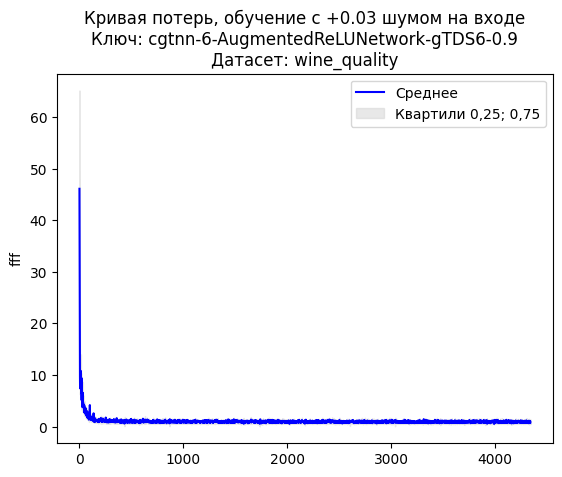

In [33]:
import re

import pandas as pd

import matplotlib.pyplot as plt

from cgtnnlib.Report import get_reports_list, Report
from cgtnnlib.analyze import plot_deviant_curves_on_ax_or_plt


reports = [
    re.split(r"[-_]", filename.rstrip('.json')) + [filename]
    for filename in get_reports_list()
]

df = pd.DataFrame(reports, columns=['project', 'dataset', 'model_class', 'noise_generator', 'p', 'iteration', 'filename'])
df['dataset'] = df['dataset'].apply(lambda x: int(x.rstrip('Y')))
df['p'] = df['p'].apply(lambda x: float(x.lstrip('P')))
df['iteration'] = df['iteration'].apply(lambda x: int(x.lstrip('N')))

def grouping_key(row):
    return f"{row.project}-{row.dataset}-{row.model_class}-{row.noise_generator}-{row.p}"

df['grouping_key'] = df.apply(grouping_key, axis=1)


def summarize_series_list(series_list: list[pd.Series]):
    df = pd.DataFrame(series_list).T

    summary_df = pd.DataFrame({
        0.25: df.quantile(0.25, axis=1),
        0.75: df.quantile(0.75, axis=1),
        'mean': df.mean(axis=1),
    })

    return summary_df


grouped = df.groupby('grouping_key')
for grouping_key, rows in grouped:
    print('group', grouping_key)
    print('rows', type(rows))

    losses: list[pd.DataFrame] = []
    evals: list[pd.DataFrame] = []

    reports = [
        Report(dir='pth/', filename=filename)
        for filename in rows['filename']
    ]
    
    curve = summarize_series_list(
        list(map(lambda x: pd.Series(x.get('loss')), reports))
    )

    plot_deviant_curves_on_ax_or_plt(
        ax_or_plt=plt,
        models=[{
            'curve': curve,
            'color': 'blue',
            'label': 'Среднее',
            'quantiles_color': 'lightgray',
            'quantiles_label': 'Квартили 0,25; 0,75',
        }],
        title='\n'.join([
            'Кривая потерь, обучение с +0.03 шумом на входе',
            'Ключ: ' + grouping_key,
            'Датасет: ' + reports[0].get('dataset').get('name')
        ]),
        xlabel='',
        ylabel='fff',
        quantiles_alpha=0.5,
    )
    
    plt.show()
